In [1]:
import os
import sys; sys.path.append('..')
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.use('pdf')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)

from colorization.colorization_model import ColorizationModel
from colorization.data.transforms import *
from colorization.modules.colorization_network import ColorizationNetwork

from colorization.visualization.annealed_mean import annealed_mean_demo
from colorization.visualization.colorization_quality import \
    amt_demo, good_vs_bad_demo, raw_accuracy_demo, vgg_accuracy_demo
from colorization.visualization.finetuning import \
    finetuning_demo, finetuning_loss_comparison
from colorization.visualization.learning_curve import learning_curve_from_log
from colorization.visualization.plot import subplots
from colorization.visualization.semantic_interpretability import \
    common_confusions, gray_vs_recolorized_performance, top5_confusion_rates

In [2]:
DATA_DIR = '../data/demo/fruits'
RESOURCE_DIR = '../resources/'
MODEL_DIR = '../models/fruits_vgg'
FIGURE_DIR = '../figures'

In [3]:
def data_path(path):
    return os.path.join(DATA_DIR, path)

def good_vs_bad_path(path):
    return os.path.join(DATA_DIR, 'good_vs_bad', path)

def amt_path(path):
    return os.path.join(DATA_DIR, 'amt', path)

def savefig(filename, width=None):
    if width is not None:
        fig = plt.gcf()
        size = fig.get_size_inches()
        fig.set_size_inches(width, size[1] / size[0] * width)

    plt.savefig(os.path.join(FIGURE_DIR, filename), bbox_inches='tight', dpi=300)

In [4]:
model = ColorizationModel(ColorizationNetwork(device='cpu'))
model.load_checkpoint(os.path.join(MODEL_DIR, 'checkpoint_0000140000.tar'))

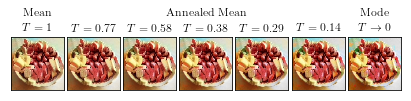

In [5]:
annealed_mean_demo(model, data_path('annealed_mean'))

savefig('annealed_mean.pdf', width=7)

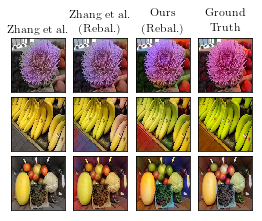

In [6]:
good_vs_bad_demo(
    good_vs_bad_path('good.txt'),
    good_vs_bad_path('bad.txt'),
    [
        (good_vs_bad_path('predict_zhang_norebal'), 'Zhang et al.'),
        (good_vs_bad_path('predict_zhang'), 'Zhang et al.\n(Rebal.)'),
        (good_vs_bad_path('predict_own'), 'Ours\n(Rebal.)'),
        (good_vs_bad_path('ground'), 'Ground\nTruth')
    ]
)

savefig('good_vs_bad.pdf', width=3.5)

In [7]:
for dataset in ['ground_truth',
                'no_color',
                'random_color',
                'predict_zhang',
                'predict_ours']:

    metrics = [
        ('AuC', partial(raw_accuracy_demo,
                        data_path('ground_truth'))),
        ('AuC rebal', partial(raw_accuracy_demo,
                              data_path('ground_truth'),
                              reweigh_classes=True)),
        ('VGG accuracy', vgg_accuracy_demo)
    ]

    table = ""
    for m, f in metrics:
        if dataset == 'ground_truth' and m.startswith('AuC'):
            val = 1
        else:
            val = f(data_path(dataset))

        table += "  {}: {}\n".format(m, val)

    print("{}:\n{}".format(dataset, table))

ground_truth:
  AuC: 1
  AuC rebal: 1
  VGG accuracy: 0.921

no_color:
  AuC: 0.7993043918609619
  AuC rebal: 0.6826628248460986
  VGG accuracy: 0.464

random_color:
  AuC: 0.7903488683700561
  AuC rebal: 0.6819156515224177
  VGG accuracy: 0.174

predict_zhang:
  AuC: 0.8376139936447143
  AuC rebal: 0.7859802499658525
  VGG accuracy: 0.677

predict_ours:
  AuC: 0.8454655694961548
  AuC rebal: 0.8095748951287435
  VGG accuracy: 0.81



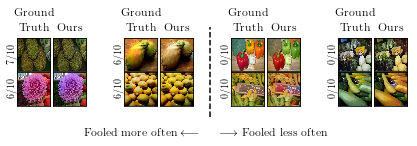

In [8]:
amt_demo(10,
         amt_path('results.txt'),
         amt_path('ground_truth'),
         amt_path('predict_ours'),
         rows=2,
         columns_best=2,
         columns_worst=2)

savefig('amt_results.pdf', width=7)

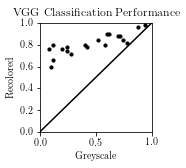

In [9]:
fig, ax = subplots(no_ticks=False)

gray_vs_recolorized_performance(
    data_path('no_color'),
    data_path('predict_ours'),
    n_top=0,
    n_bottom=0,
    ax=ax
)

savefig('vgg_classification_performance.pdf', width=2)

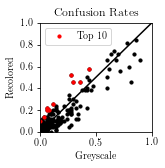

In [10]:
fig, ax = subplots(no_ticks=False)

top5_confusion_rates(
    data_path('ground_truth'),
    data_path('predict_ours'),
    n_top=10,
    ax=ax
)

savefig('confusion_rates.pdf', width=2)

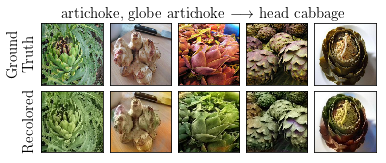

In [11]:
fig, axes = subplots(2, 5, use_gridspec=True, grid_spacing=0.1)

common_confusions(
    data_path('ground_truth'),
    data_path('predict_ours'),
    which=0,
    n_per_class=5,
    axes=axes
)

savefig('common_confusions.pdf', width=6)